rlut:long_name = "TOA Outgoing Longwave Radiation" (OLR: change sign cause is outgoing energy: cooling)

rsds:long_name = "Surface Downwelling Shortwave Radiation"

rsus:long_name = "Surface Upwelling Shortwave Radiation"

rsut:long_name = "TOA Outgoing Shortwave Radiation" (change sign: Outgoing SW → reflected sunlight → cooling)

rlds:long_name = "Surface Downwelling Longwave Radiation"

rlus:long_name = "Surface Upwelling Longwave Radiation"

rlns:long_name = "Surface net thermal radiation"

rlnt:long_name = "Top net thermal radiation" 

rsdt:long_name = "TOA Incident Shortwave Radiation" (incoming energy from the sun → warming)

rsns:long_name = "Surface net solar radiation"

rsnt:long_name = "Top net solar radiation"


TOA net vs Tsurf, OLR vs Tsurf, NetSW vs Tsurf etc.


### Import libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd
import os
from pathlib import Path

In [2]:
%matplotlib inline

### Import Functions

In [3]:
from lib import load_variable, compute_gregory_slope, read_feedback_file, enrich_with_feedbacks, plot_grouped_gregory, process_simulation, batch_process

### Import dataset

In [4]:
#tunecs 
sim_dirs = {
    "pi9r": "/work/users/malbanese/slope_fit/data/tunecs/pi9r",
    "pic9": "/work/users/malbanese/slope_fit/data/tunecs/pic9", 
    "c4c9": "/work/users/malbanese/slope_fit/data/tunecs/c4c9",
    "c49r": "/work/users/malbanese/slope_fit/data/tunecs/c49r"
}

In [4]:
#tunecs pi
sim_dirs = {
    "pi9r": "/work/users/malbanese/slope_fit/data/tunecs/pi9r",
    "pic9": "/work/users/malbanese/slope_fit/data/tunecs/pic9"
}

In [4]:
#tunecs abrupt
sim_dirs = {
    "c4c9": "/work/users/malbanese/slope_fit/data/tunecs/c4c9",
    "c49r": "/work/users/malbanese/slope_fit/data/tunecs/c49r"
}

In [4]:
#ece4 lr pd
sim_dirs = {
    "c4c9": "/work/users/malbanese/slope_fit/data/tunecs/c4c9",
    "c49r": "/work/users/malbanese/slope_fit/data/tunecs/c49r",
    "c4C": "/work/users/malbanese/slope_fit/data/tunecs/c4",
    "ece4_lr": "/work/users/malbanese/slope_fit/data/ece4_lr"
}

In [5]:
#tunecs
var_pairs = [
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": ["rlut_year_fldmean_pi9r.nc", "rsut_year_fldmean_pi9r.nc", "rsdt_year_fldmean_pi9r.nc"], "label": "pi9r_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": ["rlut_year_fldmean_pic9.nc", "rsut_year_fldmean_pic9.nc", "rsdt_year_fldmean_pic9.nc"], "label": "pic9_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": "rlut_year_fldmean_pic9.nc", "label": "pic9_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": "rlut_year_fldmean_pi9r.nc", "label": "pi9r_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": "rsut_year_fldmean_pi9r.nc", "label": "pi9r_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": "rsut_year_fldmean_pic9.nc", "label": "pic9_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": ["rlutcs_year_fldmean_pi9r.nc", "rsutcs_year_fldmean_pi9r.nc", "rsdt_year_fldmean_pi9r.nc"], "label": "pi9r_Net_TOA_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": ["rlutcs_year_fldmean_pic9.nc", "rsutcs_year_fldmean_pic9.nc", "rsdt_year_fldmean_pic9.nc"], "label": "pic9_Net_TOA_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": "rlutcs_year_fldmean_pic9.nc", "label": "pic9_OLR_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": "rlutcs_year_fldmean_pi9r.nc", "label": "pi9r_OLR_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": "rsutcs_year_fldmean_pi9r.nc", "label": "pi9r_Reflected_SW_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": "rsutcs_year_fldmean_pic9.nc", "label": "pic9_Reflected_SW_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": ["rlut_year_fldmean_c4c9.nc", "rsut_year_fldmean_c4c9.nc", "rsdt_year_fldmean_c4c9.nc"], "label": "c4c9_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": ["rlut_year_fldmean_c49r.nc", "rsut_year_fldmean_c49r.nc", "rsdt_year_fldmean_c49r.nc"], "label": "c49r_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rlut_year_fldmean_c4c9.nc", "label": "c4c9_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rlut_year_fldmean_c49r.nc", "label": "c49r_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rsut_year_fldmean_c4c9.nc", "label": "c4c9_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rsut_year_fldmean_c49r.nc", "label": "c49r_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": ["rlutcs_year_fldmean_c4c9.nc", "rsutcs_year_fldmean_c4c9.nc", "rsdt_year_fldmean_c4c9.nc"], "label": "c4c9_Net_TOA_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": ["rlutcs_year_fldmean_c49r.nc", "rsutcs_year_fldmean_c49r.nc", "rsdt_year_fldmean_c49r.nc"], "label": "c49r_Net_TOA_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rlutcs_year_fldmean_c4c9.nc", "label": "c4c9_OLR_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rlutcs_year_fldmean_c49r.nc", "label": "c49r_OLR_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rsutcs_year_fldmean_c4c9.nc", "label": "c4c9_Reflected_SW_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rsutcs_year_fldmean_c49r.nc", "label": "c49r_Reflected_SW_CS", "outlier_method": "None", "show_all": False}
]

In [ ]:
#tunecs
var_pairs = [
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": ["rlut_year_fldmean_pi9r.nc", "rsut_year_fldmean_pi9r.nc", "rsdt_year_fldmean_pi9r.nc"], "label": "pi9r_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": ["rlut_year_fldmean_pic9.nc", "rsut_year_fldmean_pic9.nc", "rsdt_year_fldmean_pic9.nc"], "label": "pic9_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": "rlut_year_fldmean_pic9.nc", "label": "pic9_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": "rlut_year_fldmean_pi9r.nc", "label": "pi9r_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": "rsut_year_fldmean_pi9r.nc", "label": "pi9r_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": "rsut_year_fldmean_pic9.nc", "label": "pic9_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pi9r_5ymean.nc", "flux": ["rlut_pi9r_5ymean.nc", "rsut_pi9r_5ymean.nc", "rsdt_pi9r_5ymean.nc"], "label": "pi9r_Net_TOA_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pic9_5ymean.nc", "flux": ["rlut_pic9_5ymean.nc", "rsut_pic9_5ymean.nc", "rsdt_pic9_5ymean.nc"], "label": "pic9_Net_TOA_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pic9_5ymean.nc", "flux": "rlut_pic9_5ymean.nc", "label": "pic9_OLR_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pi9r_5ymean.nc", "flux": "rlut_pi9r_5ymean.nc", "label": "pi9r_OLR_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pi9r_5ymean.nc", "flux": "rsut_pi9r_5ymean.nc", "label": "pi9r_Reflected_SW_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pic9_5ymean.nc", "flux": "rsut_pic9_5ymean.nc", "label": "pic9_Reflected_SW_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pi9r_10ymean.nc", "flux": ["rlut_pi9r_10ymean.nc", "rsut_pi9r_10ymean.nc", "rsdt_pi9r_10ymean.nc"], "label": "pi9r_Net_TOA_10ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pic9_10ymean.nc", "flux": ["rlut_pic9_10ymean.nc", "rsut_pic9_10ymean.nc", "rsdt_pic9_10ymean.nc"], "label": "pic9_Net_TOA_10ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pic9_10ymean.nc", "flux": "rlut_pic9_10ymean.nc", "label": "pic9_OLR_10ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pi9r_10ymean.nc", "flux": "rlut_pi9r_10ymean.nc", "label": "pi9r_OLR_10ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pi9r_10ymean.nc", "flux": "rsut_pi9r_10ymean.nc", "label": "pi9r_Reflected_SW_10ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pic9_10ymean.nc", "flux": "rsut_pic9_10ymean.nc", "label": "pic9_Reflected_SW_10ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": ["rlut_year_fldmean_c4c9.nc", "rsut_year_fldmean_c4c9.nc", "rsdt_year_fldmean_c4c9.nc"], "label": "c4c9_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": ["rlut_year_fldmean_c49r.nc", "rsut_year_fldmean_c49r.nc", "rsdt_year_fldmean_c49r.nc"], "label": "c49r_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rlut_year_fldmean_c4c9.nc", "label": "c4c9_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rlut_year_fldmean_c49r.nc", "label": "c49r_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rsut_year_fldmean_c4c9.nc", "label": "c4c9_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rsut_year_fldmean_c49r.nc", "label": "c49r_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_c4c9_5ymean.nc", "flux": ["rlut_c4c9_5ymean.nc", "rsut_c4c9_5ymean.nc", "rsdt_c4c9_5ymean.nc"], "label": "c4c9_Net_TOA_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_c49r_5ymean.nc", "flux": ["rlut_c49r_5ymean.nc", "rsut_c49r_5ymean.nc", "rsdt_c49r_5ymean.nc"], "label": "c49r_Net_TOA_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_c4c9_5ymean.nc", "flux": "rlut_c4c9_5ymean.nc", "label": "c4c9_OLR_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_c49r_5ymean.nc", "flux": "rlut_c49r_5ymean.nc", "label": "c49r_OLR_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_c4c9_5ymean.nc", "flux": "rsut_c4c9_5ymean.nc", "label": "c4c9_Reflected_SW_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_c49r_5ymean.nc", "flux": "rsut_c49r_5ymean.nc", "label": "c49r_Reflected_SW_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_c4c9_10ymean.nc", "flux": ["rlut_c4c9_10ymean.nc", "rsut_c4c9_10ymean.nc", "rsdt_c4c9_10ymean.nc"], "label": "c4c9_Net_TOA_10ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_c49r_10ymean.nc", "flux": ["rlut_c49r_10ymean.nc", "rsut_c49r_10ymean.nc", "rsdt_c49r_10ymean.nc"], "label": "c49r_Net_TOA_10ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_c4c9_10ymean.nc", "flux": "rlut_c4c9_10ymean.nc", "label": "c4c9_OLR_10ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_c49r_10ymean.nc", "flux": "rlut_c49r_10ymean.nc", "label": "c49r_OLR_10ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_c4c9_10ymean.nc", "flux": "rsut_c4c9_10ymean.nc", "label": "c4c9_Reflected_SW_10ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_c49r_10ymean.nc", "flux": "rsut_c49r_10ymean.nc", "label": "c49r_Reflected_SW_10ym", "outlier_method": "None", "show_all": False}
]

In [6]:
var_pairs = [
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": ["rlut_year_fldmean_pi9r.nc", "rsut_year_fldmean_pi9r.nc", "rsdt_year_fldmean_pi9r.nc"], "label": "pi9r_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": ["rlut_year_fldmean_pic9.nc", "rsut_year_fldmean_pic9.nc", "rsdt_year_fldmean_pic9.nc"], "label": "pic9_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": "rlut_year_fldmean_pic9.nc", "label": "pic9_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": "rlut_year_fldmean_pi9r.nc", "label": "pi9r_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": "rsut_year_fldmean_pi9r.nc", "label": "pi9r_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": "rsut_year_fldmean_pic9.nc", "label": "pic9_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pi9r_5ymean.nc", "flux": ["rlut_pi9r_5ymean.nc", "rsut_pi9r_5ymean.nc", "rsdt_pi9r_5ymean.nc"], "label": "pi9r_Net_TOA_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pic9_5ymean.nc", "flux": ["rlut_pic9_5ymean.nc", "rsut_pic9_5ymean.nc", "rsdt_pic9_5ymean.nc"], "label": "pic9_Net_TOA_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pic9_5ymean.nc", "flux": "rlut_pic9_5ymean.nc", "label": "pic9_OLR_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pi9r_5ymean.nc", "flux": "rlut_pi9r_5ymean.nc", "label": "pi9r_OLR_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pi9r_5ymean.nc", "flux": "rsut_pi9r_5ymean.nc", "label": "pi9r_Reflected_SW_5ym", "outlier_method": "None", "show_all": False},
    {"ts": "ts_pic9_5ymean.nc", "flux": "rsut_pic9_5ymean.nc", "label": "pic9_Reflected_SW_5ym", "outlier_method": "None", "show_all": False}
]

In [5]:
#tunecs pi
var_pairs = [
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": ["rlut_year_fldmean_pi9r.nc", "rsut_year_fldmean_pi9r.nc", "rsdt_year_fldmean_pi9r.nc"], "label": "pi9r_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": ["rlut_year_fldmean_pic9.nc", "rsut_year_fldmean_pic9.nc", "rsdt_year_fldmean_pic9.nc"], "label": "pic9_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": "rlut_year_fldmean_pic9.nc", "label": "pic9_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": "rlut_year_fldmean_pi9r.nc", "label": "pi9r_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": "rsut_year_fldmean_pi9r.nc", "label": "pi9r_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": "rsut_year_fldmean_pic9.nc", "label": "pic9_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": ["rlutcs_year_fldmean_pi9r.nc", "rsutcs_year_fldmean_pi9r.nc", "rsdt_year_fldmean_pi9r.nc"], "label": "pi9r_Net_TOA_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": ["rlutcs_year_fldmean_pic9.nc", "rsutcs_year_fldmean_pic9.nc", "rsdt_year_fldmean_pic9.nc"], "label": "pic9_Net_TOA_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": "rlutcs_year_fldmean_pic9.nc", "label": "pic9_OLR_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": "rlutcs_year_fldmean_pi9r.nc", "label": "pi9r_OLR_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pi9r.nc", "flux": "rsutcs_year_fldmean_pi9r.nc", "label": "pi9r_Reflected_SW_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_pic9.nc", "flux": "rsutcs_year_fldmean_pic9.nc", "label": "pic9_Reflected_SW_CS", "outlier_method": "None", "show_all": False},
]

In [5]:
#tunecs abrupt
var_pairs = [
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": ["rlut_year_fldmean_c4c9.nc", "rsut_year_fldmean_c4c9.nc", "rsdt_year_fldmean_c4c9.nc"], "label": "c4c9_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": ["rlut_year_fldmean_c49r.nc", "rsut_year_fldmean_c49r.nc", "rsdt_year_fldmean_c49r.nc"], "label": "c49r_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rlut_year_fldmean_c4c9.nc", "label": "c4c9_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rlut_year_fldmean_c49r.nc", "label": "c49r_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rsut_year_fldmean_c4c9.nc", "label": "c4c9_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rsut_year_fldmean_c49r.nc", "label": "c49r_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": ["rlutcs_year_fldmean_c4c9.nc", "rsutcs_year_fldmean_c4c9.nc", "rsdt_year_fldmean_c4c9.nc"], "label": "c4c9_Net_TOA_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": ["rlutcs_year_fldmean_c49r.nc", "rsutcs_year_fldmean_c49r.nc", "rsdt_year_fldmean_c49r.nc"], "label": "c49r_Net_TOA_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rlutcs_year_fldmean_c4c9.nc", "label": "c4c9_OLR_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rlutcs_year_fldmean_c49r.nc", "label": "c49r_OLR_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rsutcs_year_fldmean_c4c9.nc", "label": "c4c9_Reflected_SW_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rsutcs_year_fldmean_c49r.nc", "label": "c49r_Reflected_SW_CS", "outlier_method": "None", "show_all": False}
]

In [5]:
#ece4 lr pd
var_pairs = [
    {"ts": "ts_year_fldmean.nc", "flux": ["rlut_year_fldmean.nc", "rsut_year_fldmean.nc", "rsdt_year_fldmean.nc"], "label": "ece4_lr_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean.nc", "flux": "rlut_year_fldmean.nc", "label": "ece4_lr_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean.nc", "flux": "rsut_year_fldmean.nc", "label": "ece4_lr_Reflected_SW", "outlier_method": "None", "show_all": False},
    #{"ts": "ts_year_fldmean.nc", "flux": "rsnt_5ymean.nc", "label": "ece4_lr_Net_SW_TOA_5ymean", "outlier_method": "None", "show_all": False},
    #{"ts": "ts_year_fldmean.nc", "flux": "rlnt_5ymean.nc", "label": "ece4_lr_Net_LW_TOA_5ymean", "outlier_method": "None", "show_all": False},
    #{"ts": "ts_year_fldmean.nc", "flux": "rsntcs_year_fldmean.nc", "label": "ece4_lr_ClearSky_Net_SW_TOA_year_fldmean", "outlier_method": "None", "show_all": False},
    #{"ts": "ts_year_fldmean.nc", "flux": "rlntcs_year_fldmean.nc", "label": "ece4_lr_ClearSky_Net_LW_TOA_year_fldmean", "outlier_method": "None", "show_all": False}, 
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": ["rlut_year_fldmean_c4c9.nc", "rsut_year_fldmean_c4c9.nc", "rsdt_year_fldmean_c4c9.nc"], "label": "c4c9_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": ["rlut_year_fldmean_c49r.nc", "rsut_year_fldmean_c49r.nc", "rsdt_year_fldmean_c49r.nc"], "label": "c49r_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rlut_year_fldmean_c4c9.nc", "label": "c4c9_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rlut_year_fldmean_c49r.nc", "label": "c49r_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rsut_year_fldmean_c4c9.nc", "label": "c4c9_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rsut_year_fldmean_c49r.nc", "label": "c49r_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": ["rlutcs_year_fldmean_c4c9.nc", "rsutcs_year_fldmean_c4c9.nc", "rsdt_year_fldmean_c4c9.nc"], "label": "c4c9_Net_TOA_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": ["rlutcs_year_fldmean_c49r.nc", "rsutcs_year_fldmean_c49r.nc", "rsdt_year_fldmean_c49r.nc"], "label": "c49r_Net_TOA_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rlutcs_year_fldmean_c4c9.nc", "label": "c4c9_OLR_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rlutcs_year_fldmean_c49r.nc", "label": "c49r_OLR_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4c9.nc", "flux": "rsutcs_year_fldmean_c4c9.nc", "label": "c4c9_Reflected_SW_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c49r.nc", "flux": "rsutcs_year_fldmean_c49r.nc", "label": "c49r_Reflected_SW_CS", "outlier_method": "None", "show_all": False}, 
    {"ts": "ts_year_fldmean_c4.nc", "flux": ["rlut_year_fldmean_c4.nc", "rsut_year_fldmean_c4.nc", "rsdt_year_fldmean_c4.nc"], "label": "c4C_Net_TOA", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4.nc", "flux": ["rlutcs_year_fldmean_c4.nc", "rsutcs_year_fldmean_c4.nc", "rsdt_year_fldmean_c4.nc"], "label": "c4C_Net_TOA_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4.nc", "flux": "rlut_year_fldmean_c4.nc", "label": "c4C_OLR", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4.nc", "flux": "rsut_year_fldmean_c4.nc", "label": "c4C_Reflected_SW", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4.nc", "flux": "rlutcs_year_fldmean_c4.nc", "label": "c4C_OLR_CS", "outlier_method": "None", "show_all": False},
    {"ts": "ts_year_fldmean_c4.nc", "flux": "rsutcs_year_fldmean_c4.nc", "label": "c4C_Reflected_SW_CS", "outlier_method": "None", "show_all": False}
]

In [6]:
results = [] 
for sim, folder in sim_dirs.items():
    sim_var_pairs = [pair for pair in var_pairs if sim in pair["label"]]
    df = batch_process(folder, sim_var_pairs, save_plot_dir=f"plots/{sim}")
    results.append(df)

final_df = pd.concat(results, ignore_index=True)

# Sort to interleave pi9r and pic9 for same flux type
final_df['flux_type'] = final_df['label'].apply(lambda x: x.split('_', 1)[1])
final_df = final_df.sort_values(by='flux_type').drop(columns='flux_type').reset_index(drop=True)

feedback_to_add = ["albedo"]  # personalizza la lista

final_df = enrich_with_feedbacks(final_df, feedback_folder="/work/users/malbanese/slope_fit/data/tunecs/feedbacks", feedback_names=feedback_to_add)

# Optional: display or save
display(final_df)

,label,slope,intercept,x_intercept,r2,std_err,tsurf,flux,outliers,group,albedo_fb,albedo_err,albedo_cs_fb,albedo_cs_err
0,pi9r_Net_TOA,-0.331362,95.456662,288.074055,0.065868,0.102922,[<xarray.DataArray 'ts' ()> Size: 4B\narray(28...,[<xarray.DataArray 'rlut' ()> Size: 4B\narray(...,"[False, False, False, False, False, False, Fal...",pi9r,0.8497,0.1018,<NA>,<NA>
1,c4c9_Net_TOA,-0.759694,226.144016,297.677740,0.888176,0.022233,[<xarray.DataArray 'ts' ()> Size: 4B\narray(28...,[<xarray.DataArray 'rlut' ()> Size: 4B\narray(...,"[False, False, False, False, False, False, Fal...",c4c9,0.509757,0.013106,<NA>,<NA>
2,c49r_Net_TOA,-0.931860,275.523169,295.670106,0.891714,0.026783,[<xarray.DataArray 'ts' ()> Size: 4B\narray(28...,[<xarray.DataArray 'rlut' ()> Size: 4B\narray(...,"[False, False, False, False, False, False, Fal...",c49r,0.568594,0.009412,<NA>,<NA>
3,pic9_Net_TOA,-0.337586,97.676208,289.337156,0.038061,0.139978,[<xarray.DataArray 'ts' ()> Size: 4B\narray(28...,[<xarray.DataArray 'rlut' ()> Size: 4B\narray(...,"[False, False, False, False, False, False, Fal...",pic9,1.0063,0.1165,<NA>,<NA>
4,c4c9_Net_TOA_CS,-0.850491,272.023496,319.842828,0.985936,0.008378,[<xarray.DataArray 'ts' ()> Size: 4B\narray(28...,[<xarray.DataArray 'rlutcs' ()> Size: 4B\narra...,"[False, False, False, False, False, False, Fal...",c4c9,<NA>,<NA>,0.680942,0.020906
5,pic9_Net_TOA_CS,-0.367394,124.197044,338.048656,0.096360,0.092795,[<xarray.DataArray 'ts' ()> Size: 4B\narray(28...,[<xarray.DataArray 'rlutcs' ()> Size: 4B\narra...,"[False, False, False, False, False, False, Fal...",pic9,<NA>,<NA>,1.501,0.1431
6,pi9r_Net_TOA_CS,-0.286996,99.338960,346.133525,0.087605,0.076392,[<xarray.DataArray 'ts' ()> Size: 4B\narray(28...,[<xarray.DataArray 'rlutcs' ()> Size: 4B\narra...,"[False, False, False, False, False, False, Fal...",pi9r,<NA>,<NA>,1.3655,0.1428
7,c49r_Net_TOA_CS,-0.835027,265.417571,317.854999,0.978704,0.010159,[<xarray.DataArray 'ts' ()> Size: 4B\narray(28...,[<xarray.DataArray 'rlutcs' ()> Size: 4B\narra...,"[False, False, False, False, False, False, Fal...",c49r,<NA>,<NA>,0.781813,0.015909
8,pic9_OLR,-1.526779,202.355951,132.537776,0.765906,0.069618,[<xarray.DataArray 'ts' ()> Size: 4B\narray(28...,[<xarray.DataArray 'rlut' ()> Size: 4B\narray(...,"[False, False, False, False, False, False, Fal...",pic9,1.0063,0.1165,<NA>,<NA>
9,c4c9_OLR,-1.612037,233.480341,144.835573,0.994575,0.009819,[<xarray.DataArray 'ts' ()> Size: 4B\narray(28...,[<xarray.DataArray 'rlut' ()> Size: 4B\narray(...,"[False, False, False, False, False, False, Fal...",c4c9,0.509757,0.013106,<NA>,<NA>


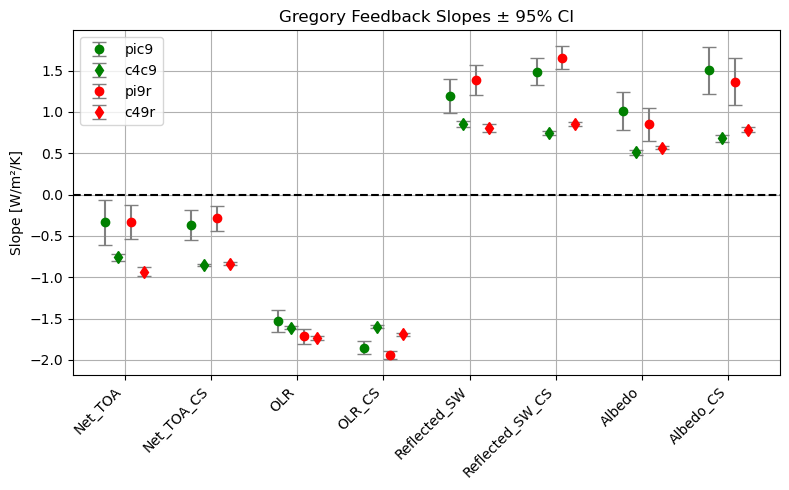

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Extract components
final_df["sim"] = final_df["label"].apply(lambda x: x.split("_")[0].strip())      # pi9r or pic9
final_df["flux"] = final_df["label"].apply(lambda x: x.split("_", 1)[1])   # e.g. Net_TOA

final_df["flux"] = final_df["flux"].str.replace("^lr_", "", regex=True)
# Determina i tipi di flusso (dalla colonna "flux") + aggiungi "Albedo" alla lista
flux_types = list(final_df["flux"].unique())
flux_types.extend(["Albedo", "Albedo_CS"])

# Create x positions: one group per flux type
x_base = np.arange(len(flux_types))  # 0, 1, 2, ...

# Define style: same color for tuning family, same marker for tuning/retuned
sim_styles = {
    "pic9":  {"color": "green",  "marker": "o"},
    "c4c9":  {"color": "green",  "marker": "d"},
    "pi9r":  {"color": "red", "marker": "o"},
    "c49r":  {"color": "red", "marker": "d"}
}

# Plot setup
plt.figure(figsize=(8, 5))
width = 0.15  # Horizontal spread

for i, flux in enumerate(flux_types):
    if flux == "Albedo":
        # Prendi la riga *senza* _CS per ogni sim
        df_flux = final_df[~final_df["label"].str.contains("_CS")].drop_duplicates("sim")[["sim", "albedo_fb", "albedo_err"]].copy()
        df_flux = df_flux.rename(columns={"albedo_fb": "slope", "albedo_err": "std_err"})
    elif flux == "Albedo_CS":
        # Prendi la riga *con* _CS per ogni sim
        df_flux = final_df[final_df["label"].str.contains("_CS")].drop_duplicates("sim")[["sim", "albedo_cs_fb", "albedo_cs_err"]].copy()
        df_flux = df_flux.rename(columns={"albedo_cs_fb": "slope", "albedo_cs_err": "std_err"})
    else:
        df_flux = final_df[final_df["flux"] == flux]

    for j, sim in enumerate(sim_styles.keys()):
        row = df_flux[df_flux["sim"] == sim]
        if not row.empty:
            y = row["slope"].values[0]
            err = row["std_err"].values[0]

            # Controllo valori validi numerici
            if pd.isna(y) or pd.isna(err):
                continue  # salta se manca il valore

            err = 1.96 * err  # 95% CI

            x = x_base[i] + (j - 1.5) * width  # Spread horizontally

            plt.errorbar(
                x, y, yerr=err, fmt=sim_styles[sim]["marker"],
                color=sim_styles[sim]["color"], capsize=5, ecolor='gray',
                label=sim if i == 0 else ""  # Avoid repeated legends
            )

# Aesthetics
plt.axhline(0, color='black', linestyle='--')
plt.xticks(x_base, flux_types, rotation=45, ha='right')
plt.ylabel("Slope [W/m²/K]")
plt.title("Gregory Feedback Slopes ± 95% CI")
plt.grid(True)

# Unique legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

plt.tight_layout()
plt.savefig("grouped_gregory_slopes_95CI.png")
plt.show()

Plot salvato in: plots/comparisons/Net_TOA_vs_Net_TOA_5ym.png


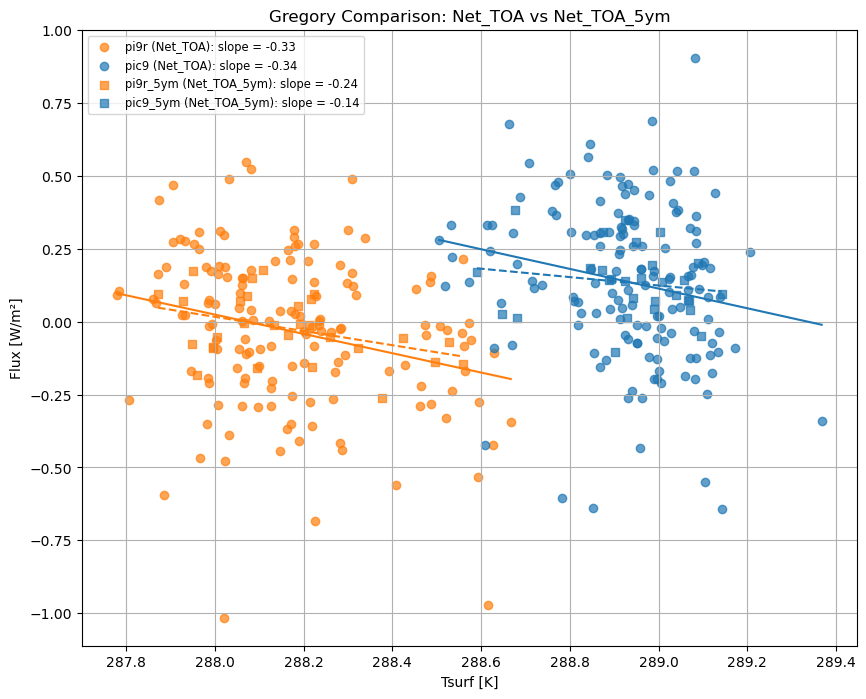

Plot salvato in: plots/comparisons/OLR_vs_OLR_5ym.png


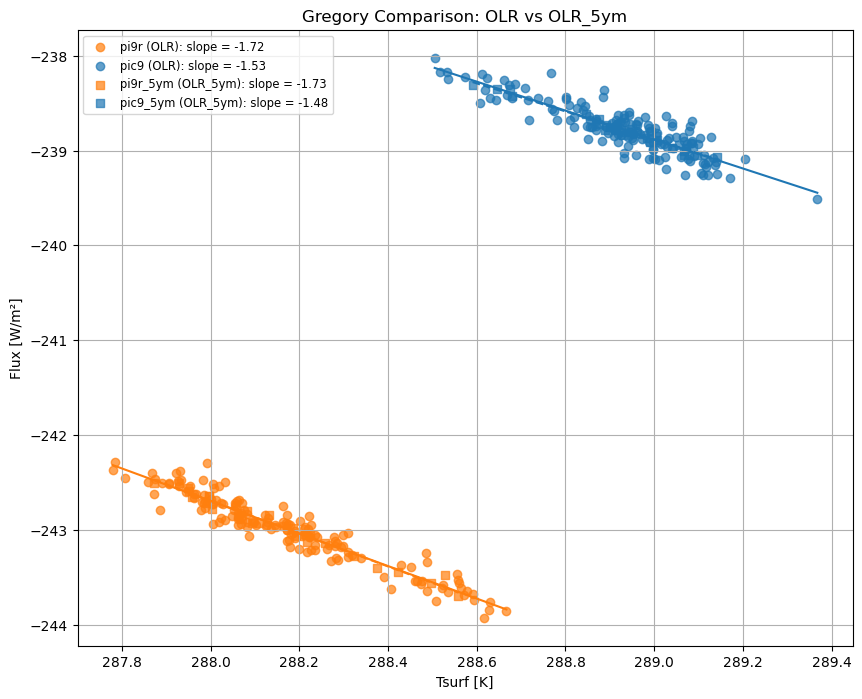

Plot salvato in: plots/comparisons/Reflected_SW_vs_Reflected_SW_5ym.png


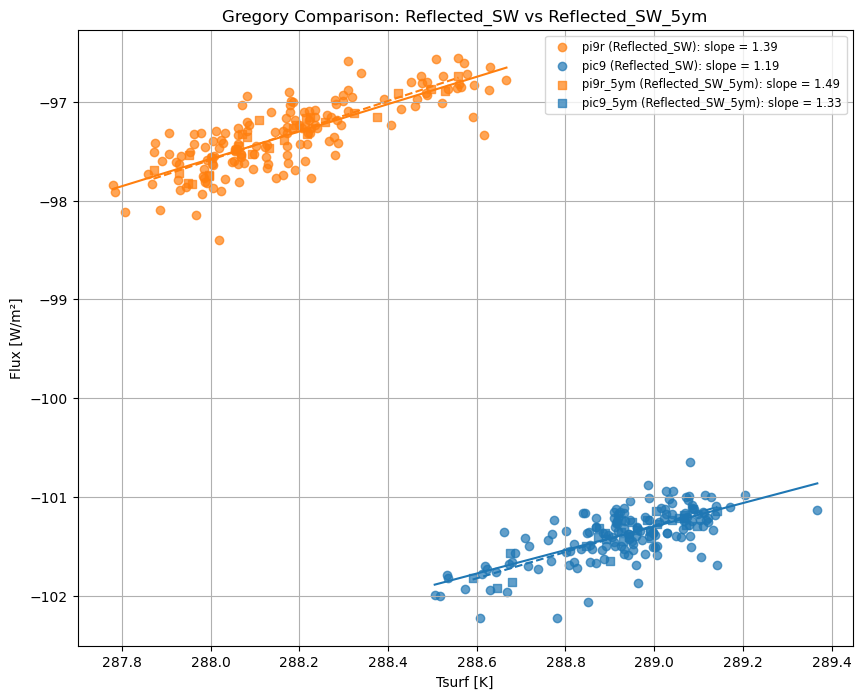

In [8]:
# Add slope, tsurf, flux, outliers back to final_df (already returned by compute_gregory_slope)
full_results = []
for sim, folder in sim_dirs.items():
    sim_var_pairs = [pair for pair in var_pairs if sim in pair["label"]]
    df = batch_process(folder, sim_var_pairs, save_plot_dir=f"plots/{sim}")
    full_results.append(df)

# Concatenate and use
full_df = pd.concat(full_results, ignore_index=True)

flux_groups = [
    ["Net_TOA", "Net_TOA_5ym"],       # Compare standard and clear-sky TOA
    ["OLR", "OLR_5ym"],               # Compare standard and clear-sky OLR
    ["Reflected_SW", "Reflected_SW_5ym"]  # Same for reflected SW
]

for flux_group in flux_groups:
    plot_grouped_gregory(full_df, flux_group, save_dir="plots/comparisons", show_outliers=False)